In [1]:
import os
import cv2
import random 
import json
from functools import partial
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from pathlib import Path

In [2]:
#load existing model for training
model = keras.models.load_model("C:/Users/moony/Desktop/toys/controllers/my_controller/cross/kimbasa2.keras")

In [2]:
#create new model
model = keras.Sequential(
    [
        keras.layers.Conv2D(32, 3, activation='relu',input_shape=[180,320, 3]),
        keras.layers.Conv2D(32, 3, activation='relu'),
        keras.layers.Conv2D(32, 3, activation='relu'),
        keras.layers.Conv2D(32, 3, activation='relu'),
        # DefaultConv2D(filters=64, kernel_size=7, input_shape=[320,180, 3]),
        keras.layers.MaxPooling2D(pool_size=2),
        keras.layers.Conv2D(32, 3, activation='relu'),
        keras.layers.Conv2D(64, 3, activation='relu'),
        keras.layers.Conv2D(64, 3, activation='relu'),
        keras.layers.MaxPooling2D(pool_size=2),
        keras.layers.Conv2D(64, 3, activation='relu'),
        keras.layers.Conv2D(64, 3, activation='relu'),
        keras.layers.Conv2D(128, 3, activation='relu'),
        keras.layers.MaxPooling2D(pool_size=2),
        keras.layers.Flatten(),
        keras.layers.Dense(units=256, activation="relu"),
        keras.layers.Dropout(0.01), 
        keras.layers.Dense(units=128, activation="relu"),
        keras.layers.Dropout(0.01), 
        keras.layers.Dense(units=128, activation="relu"),
        keras.layers.Dropout(0.01), 
        keras.layers.Dense(units=64, activation="relu"),
        keras.layers.Dropout(0.01), 
        keras.layers.Dense(units=2, activation="relu")
    ]
)

In [2]:
#create new leakyrelu model
model = keras.Sequential(
    [
        keras.layers.Conv2D(32, 3, activation=keras.layers.LeakyReLU(0.1),input_shape=[180,320, 3]),
        keras.layers.Conv2D(32, 3, activation=keras.layers.LeakyReLU(0.1)),
        keras.layers.Conv2D(32, 3, activation=keras.layers.LeakyReLU(0.1)),
        keras.layers.Conv2D(32, 3, activation=keras.layers.LeakyReLU(0.1)),
        keras.layers.MaxPooling2D(pool_size=2),
        keras.layers.Conv2D(64, 3, activation=keras.layers.LeakyReLU(0.1)),
        keras.layers.Conv2D(64, 3, activation=keras.layers.LeakyReLU(0.1)),
        keras.layers.Conv2D(64, 3, activation=keras.layers.LeakyReLU(0.1)),
        keras.layers.MaxPooling2D(pool_size=2),
        keras.layers.Conv2D(64, 3, activation=keras.layers.LeakyReLU(0.1)),
        keras.layers.Conv2D(64, 3, activation=keras.layers.LeakyReLU(0.1)),
        keras.layers.Conv2D(64, 3, activation=keras.layers.LeakyReLU(0.1)),
        keras.layers.MaxPooling2D(pool_size=2),
        keras.layers.Flatten(),
        keras.layers.Dense(units=128, activation=keras.layers.LeakyReLU(0.1)),
        keras.layers.Dropout(0.01), 
        keras.layers.Dense(units=128, activation=keras.layers.LeakyReLU(0.1)),
        keras.layers.Dropout(0.01), 
        keras.layers.Dense(units=128, activation=keras.layers.LeakyReLU(0.1)),
        keras.layers.Dropout(0.01), 
        keras.layers.Dense(units=64, activation=keras.layers.LeakyReLU(0.1)),
        keras.layers.Dropout(0.01), 
        keras.layers.Dense(units=2, activation=keras.layers.LeakyReLU(0.1))
    ]
)

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 178, 318, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 176, 316, 32)      9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 174, 314, 32)      9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 172, 312, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 86, 156, 32)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 84, 154, 64)       18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 82, 152, 64)       3

In [3]:
#load data
SESSION = "1"#session
FOLDER = Path("../")
DATASET_FOLDER = FOLDER / f"dataset/{SESSION}" #dataset folder
IMAGE_FOLDER = DATASET_FOLDER / "images"#images folder
def preprocess_images(images):
    # Convert from integers to floats
    images_norm = images.astype("float32")
    # Normalize
    images_norm = images_norm / 255.0

    return images_norm
x=[]
y=[]
json_files = [el for el in DATASET_FOLDER.iterdir() if el.suffix == ".json"]
print(len(json_files))
random.seed(1)
random.shuffle(json_files)
json_files = json_files[:]#control data being taken
counters = {}
for json_file in json_files:
        with open(json_file) as f:
            sample = json.load(f)
        holder = str(sample["left"]/5)+","+str(sample["right"]/5)
        if holder in counters: 
            counters[holder] +=1
        else:
            counters[holder] = 1
        if not "-" in holder:
            x.append(cv2.resize(cv2.imread(sample["image"]), (320,180 )))
            y.append([sample["left"]/5,sample["right"]/5])
x = np.asarray(x)
x = preprocess_images(x)
y = np.asarray(y)

x_train, x_valid, y_train, y_valid = train_test_split(
    x, y, test_size=0.25, random_state=42,stratify=y
)

36078


In [10]:
counters

{'0.0,0.0': 1193, '2.0,2.0': 265, '2.0,1.0': 255, '1.0,2.0': 287}

In [4]:

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=50,
    restore_best_weights=True,
)

In [5]:
#training
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam(learning_rate=0.00001))
history2 = model.fit(
        x_train,
        y_train,
        epochs=3,
        batch_size=1,  # 32
        validation_data=(x_valid, y_valid),
        callbacks=[ early_stopping_cb],
    )

Epoch 1/3
1558/1558 [==============================] - 35s 15ms/step - loss: 0.0282 - val_loss: 0.0260
Epoch 2/3
1558/1558 [==============================] - 21s 13ms/step - loss: 0.0146 - val_loss: 0.0244
Epoch 3/3
1558/1558 [==============================] - 21s 14ms/step - loss: 0.0077 - val_loss: 0.0270


In [7]:
#save model
model.save("C:/Users/moony/Desktop/toys/controllers/my_controller/cross/kimbasa2.keras")

In [8]:
l = 3
image = x_valid[1:100]
# image = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])
prediction = np.array(model(image, training=False))

ResourceExhaustedError: OOM when allocating tensor with shape[99,32,178,318] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2D]

In [ ]:
print(wrongs,wrongg)

In [ ]:
wrongs = 0
wrongg = 0
for i in range(len(y_valid[1:100])):
    if y_valid[i][0] != 0 and prediction[i][0] ==0:
        wrongs+=1
    elif y_valid[i][0] == 0 and prediction[i][0] !=0:
        wrongg+=1
    print(i,y_valid[i],prediction[i])

In [16]:
y_valid[l]

array([2., 2.])

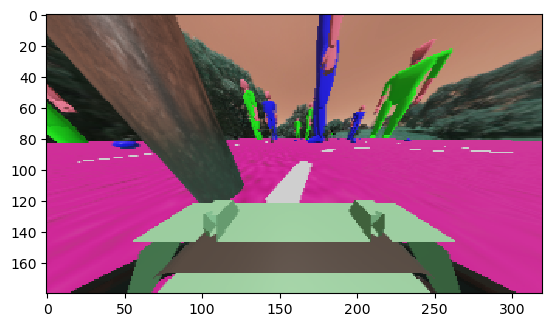

In [14]:
image = x_valid[97]


from matplotlib import pyplot as plt
plt.imshow(image, interpolation='nearest')
plt.show()

In [8]:
model.save("C:/Users/moony/Desktop/toys/controllers/my_controller/aim2.keras")

In [9]:
cv2.resize(cv2.imread("C:\\Users/moony/Desktop/tdats/dataset/ouch/images/image_0"), (320,180 ))

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


In [52]:
x = cv2.resize(cv2.imread("C:/Users/moony/Desktop/tdats/dataset/ouch/images/image_0.png"), (320,180))

In [53]:
preprocess_images(x)

array([[[0.52156866, 0.34509805, 0.28235295],
        [0.5176471 , 0.34509805, 0.2784314 ],
        [0.5176471 , 0.34117648, 0.2784314 ],
        ...,
        [0.43529412, 0.28235295, 0.23137255],
        [0.43529412, 0.28235295, 0.23137255],
        [0.43529412, 0.28235295, 0.23137255]],

       [[0.52156866, 0.34509805, 0.28235295],
        [0.52156866, 0.34509805, 0.28235295],
        [0.52156866, 0.34509805, 0.2784314 ],
        ...,
        [0.43529412, 0.28235295, 0.23137255],
        [0.43529412, 0.28235295, 0.23137255],
        [0.43529412, 0.28235295, 0.23137255]],

       [[0.52156866, 0.34901962, 0.28235295],
        [0.52156866, 0.34509805, 0.28235295],
        [0.52156866, 0.34509805, 0.28235295],
        ...,
        [0.43529412, 0.28235295, 0.23137255],
        [0.4392157 , 0.28235295, 0.23137255],
        [0.44313726, 0.28235295, 0.23137255]],

       ...,

       [[0.14509805, 0.11764706, 0.10588235],
        [0.14509805, 0.11764706, 0.10588235],
        [0.14509805, 0